 # REAL TIME SIGN LANGUAGE TRANSLATION


#### Author: Anirudh Mishra

## 1. Import Dependencies

In [1]:
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import time
import mediapipe as mp
import tensorflow as tf
from sklearn.model_selection import train_test_split

## 2. Keypoints using MediaPipe Holistics

In [2]:
# 2. Keypoints using MP Holistics
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

In [3]:
# Function to detect mediapipe landmarks
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR CONVERSION RGB to BGR
    return image, results

In [4]:
# Function to draw landmarks on the image
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                               mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                               mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                               mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                               mp_drawing.DrawingSpec(color=(80,24,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                               mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                               mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                               mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                               mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=12))

## 3. Extract Keypoints Values

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark[:10]]).flatten() if results.pose_landmarks else np.zeros(10 * 4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark[:10]]).flatten() if results.face_landmarks else np.zeros(10 * 3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark[:10]]).flatten() if results.left_hand_landmarks else np.zeros(10 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark[:10]]).flatten() if results.right_hand_landmarks else np.zeros(10 * 3)
    
    return np.concatenate([pose, face, lh, rh])


## 4. Setup Folders for Collection

In [6]:
# Path for extracted data, numpy arrays
# DATA_PATH = os.path.join('MP_Data_1')

# Actions that we try to detect
actions = np.array(['Hello', 'Thanks', 'I Love You',  'no', 'please', 'sorry', 'teacher', 'understand', 'yes', 'you'])


#Thirty videos worth of data
no_sequences=30

# Videos are going to be 30 frames in length
sequence_length=30

In [25]:
# Create directories for each action and sequence
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except Exception as e:
            print(f"Error creating directory: {e}")

Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating directory: name 'DATA_PATH' is not defined
Error creating

In [17]:
cap = cv2.VideoCapture(0)  # Use 0 for the default camera

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                if not ret:
                    break
                
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                # Display the frame information for the first frame of each sequence
                if frame_num == 0:
                    cv2.putText(image, 'START COLLECTION', (120, 120),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                cv2.imshow('OpenCV Feed', image)

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence))
                os.makedirs(npy_path, exist_ok=True)
                np.save(os.path.join(npy_path, str(frame_num)), keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    exit()

cap.release()
cv2.destroyAllWindows()

## 6. Preprocess Data and Create Labels

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map={label:num for num, label in enumerate(actions)}

In [9]:
label_map

{'Hello': 0,
 'Thanks': 1,
 'I Love You': 2,
 'no': 3,
 'please': 4,
 'sorry': 5,
 'teacher': 6,
 'understand': 7,
 'yes': 8,
 'you': 9}

In [10]:
sequences, labels =[], []
# for action in actions:
#     for sequence in range(no_sequences):
#         window=[]
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence),"{}.npy".format(frame_num)))
#             window.append(res)
#         sequences.append(window)
#         labels.append(label_map[action])

In [11]:
np.array(sequences).shape

(0,)

In [12]:
np.array(labels).shape

(0,)

In [13]:
x = np.array(sequences)

In [15]:
y= to_categorical(labels).astype(int)

ValueError: zero-size array to reduction operation maximum which has no identity

In [16]:
y

NameError: name 'y' is not defined

In [27]:
x.shape

(300, 30, 130)

In [28]:
x

array([[[ 0.58964229,  0.49512413, -0.71595007, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.50309324,  0.49312046, -0.71301639, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.48890004,  0.48865348, -0.62728101, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.47365826,  0.49869695, -0.91407287, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.46521777,  0.49912813, -0.90565956, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.45430952,  0.50306743, -0.90417022, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.45123619,  0.50478816, -0.89553672, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.44806033,  0.50871509, -0.84333581, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.44579887,  0.51460224, -0.84099615, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.43472639,  0.52540118, -0.81434363, ...,  

In [30]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.1)

In [31]:
y_test.shape

(30, 10)

## 7. Build and Train an LSTM Deep Learning Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [33]:
log_dir=os.path.join('Logs')
tb_callback=TensorBoard(log_dir=log_dir)

In [12]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 130)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))  

C:\Users\aniru\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
res=[.7,0.2,0.1]

In [37]:
 actions[np.argmax(res)]

'Hello'

In [38]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_accuracy', 'val_mae')
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores model weights from the epoch with the best validation metric
)

In [40]:
model.fit(x_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - categorical_accuracy: 0.1326 - loss: 2.2937
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - categorical_accuracy: 0.1642 - loss: 2.2450
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.2772 - loss: 2.1280
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.2572 - loss: 1.9017
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - categorical_accuracy: 0.2847 - loss: 1.8303
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - categorical_accuracy: 0.2982 - loss: 1.7197
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - categorical_accuracy: 0.2961 - loss: 1.5320
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - categorical_accuracy: 0.3753 - loss: 1.6724
Epoch 9/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.2691 - loss: 1.8625
Epoch 10/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - categorical_accuracy: 0.3314 - loss: 1.6284
Epoch 11/1000
9/9 ━━━━━━━━━━━

In [41]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 614,144 (2.34 MB)

 Trainable params: 204,714 (799.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 409,430 (1.56 MB)

## 8. Make Sign Language Predictions

In [14]:
res=model.predict(x_test)

NameError: name 'x_test' is not defined

In [43]:
actions[np.argmax(res[3])]

'Hello'

In [44]:
actions[np.argmax(y_test[1])]


'yes'

## 9. Save Model Weights

In [45]:
# model.save('signTranslate11_h5.keras')

In [7]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('signTranslate11_h5.keras')

# Check the model's architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 614,144 (2.34 MB)

 Trainable params: 204,714 (799.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 409,430 (1.56 MB)

## 10. Evaluation using a Confusion Matrix

In [5]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [8]:
  yhat=model.predict(x_train)

NameError: name 'x_train' is not defined

In [48]:
ytrue=np.argmax(y_train, axis=1).tolist()
yhat=np.argmax(yhat, axis=1).tolist()

In [49]:
yhat

[6,
 8,
 7,
 3,
 3,
 0,
 2,
 7,
 5,
 8,
 9,
 5,
 9,
 0,
 2,
 7,
 4,
 4,
 3,
 8,
 3,
 1,
 4,
 5,
 3,
 0,
 4,
 6,
 7,
 2,
 1,
 5,
 2,
 6,
 4,
 2,
 0,
 3,
 6,
 2,
 1,
 4,
 3,
 1,
 3,
 7,
 5,
 0,
 3,
 3,
 9,
 1,
 0,
 0,
 4,
 0,
 8,
 8,
 9,
 8,
 1,
 4,
 3,
 4,
 3,
 9,
 2,
 3,
 9,
 0,
 8,
 9,
 1,
 3,
 4,
 5,
 2,
 2,
 3,
 4,
 0,
 9,
 7,
 7,
 8,
 8,
 1,
 9,
 7,
 9,
 2,
 2,
 9,
 3,
 1,
 0,
 1,
 6,
 6,
 0,
 4,
 9,
 3,
 8,
 8,
 8,
 8,
 9,
 9,
 5,
 1,
 5,
 0,
 4,
 1,
 7,
 7,
 6,
 2,
 8,
 3,
 8,
 0,
 0,
 4,
 7,
 9,
 2,
 4,
 6,
 5,
 7,
 0,
 8,
 6,
 1,
 0,
 2,
 1,
 9,
 4,
 5,
 9,
 1,
 5,
 9,
 7,
 4,
 3,
 5,
 1,
 7,
 0,
 4,
 9,
 3,
 1,
 2,
 1,
 6,
 7,
 7,
 9,
 2,
 9,
 7,
 8,
 1,
 0,
 2,
 9,
 8,
 5,
 5,
 4,
 8,
 1,
 6,
 8,
 6,
 6,
 5,
 0,
 6,
 2,
 2,
 3,
 3,
 2,
 7,
 8,
 7,
 6,
 0,
 8,
 3,
 6,
 1,
 5,
 9,
 7,
 0,
 2,
 2,
 0,
 2,
 6,
 8,
 2,
 8,
 9,
 0,
 8,
 1,
 2,
 7,
 7,
 8,
 6,
 7,
 1,
 0,
 5,
 7,
 1,
 7,
 9,
 4,
 4,
 5,
 5,
 5,
 9,
 5,
 7,
 9,
 6,
 4,
 3,
 0,
 7,
 8,
 6,
 1,
 4,
 4,
 5,
 7,
 5,
 6,


In [50]:
ytrue

[6,
 8,
 7,
 3,
 3,
 0,
 2,
 7,
 5,
 8,
 9,
 5,
 9,
 0,
 2,
 7,
 4,
 4,
 3,
 8,
 3,
 1,
 4,
 5,
 3,
 0,
 4,
 6,
 7,
 2,
 1,
 5,
 2,
 6,
 4,
 2,
 0,
 3,
 6,
 2,
 1,
 4,
 3,
 1,
 3,
 7,
 5,
 0,
 3,
 3,
 9,
 1,
 0,
 0,
 4,
 0,
 8,
 8,
 9,
 8,
 1,
 4,
 3,
 4,
 3,
 9,
 2,
 3,
 9,
 0,
 8,
 9,
 1,
 3,
 4,
 6,
 2,
 2,
 3,
 4,
 0,
 9,
 7,
 7,
 8,
 8,
 1,
 9,
 7,
 9,
 2,
 2,
 9,
 3,
 1,
 0,
 1,
 6,
 6,
 0,
 4,
 9,
 3,
 8,
 8,
 8,
 8,
 9,
 9,
 5,
 1,
 5,
 0,
 4,
 1,
 7,
 7,
 6,
 2,
 8,
 3,
 8,
 0,
 0,
 4,
 7,
 9,
 2,
 4,
 6,
 5,
 7,
 0,
 8,
 6,
 1,
 0,
 2,
 1,
 9,
 4,
 5,
 9,
 1,
 5,
 9,
 7,
 4,
 3,
 6,
 1,
 7,
 0,
 4,
 9,
 3,
 1,
 2,
 1,
 6,
 7,
 7,
 9,
 2,
 9,
 7,
 8,
 1,
 0,
 2,
 9,
 8,
 5,
 5,
 4,
 8,
 1,
 6,
 8,
 6,
 6,
 5,
 0,
 6,
 2,
 2,
 3,
 3,
 2,
 7,
 8,
 7,
 6,
 0,
 8,
 3,
 6,
 1,
 5,
 9,
 7,
 0,
 2,
 2,
 0,
 2,
 6,
 8,
 2,
 8,
 9,
 0,
 8,
 1,
 2,
 7,
 7,
 8,
 6,
 7,
 1,
 0,
 5,
 7,
 1,
 7,
 9,
 4,
 4,
 5,
 5,
 5,
 9,
 5,
 7,
 9,
 6,
 4,
 3,
 0,
 7,
 8,
 6,
 1,
 4,
 4,
 5,
 7,
 5,
 6,


In [51]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[242,   0],
        [  0,  28]],

       [[241,   0],
        [  0,  29]],

       [[242,   0],
        [  0,  28]],

       [[245,   0],
        [  0,  25]],

       [[244,   0],
        [  0,  26]],

       [[245,   2],
        [  0,  23]],

       [[245,   0],
        [  2,  23]],

       [[240,   0],
        [  0,  30]],

       [[242,   0],
        [  0,  28]],

       [[242,   0],
        [  0,  28]]], dtype=int64)

In [52]:
multilabel_confusion_matrix(ytrue,yhat)

array([[[242,   0],
        [  0,  28]],

       [[241,   0],
        [  0,  29]],

       [[242,   0],
        [  0,  28]],

       [[245,   0],
        [  0,  25]],

       [[244,   0],
        [  0,  26]],

       [[245,   2],
        [  0,  23]],

       [[245,   0],
        [  2,  23]],

       [[240,   0],
        [  0,  30]],

       [[242,   0],
        [  0,  28]],

       [[242,   0],
        [  0,  28]]], dtype=int64)

In [53]:
accuracy_score(ytrue,yhat)

0.9925925925925926

## 11. Test in Real Time

In [14]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (245, 66, 230), (66, 245, 230),
          (230, 66, 245), (230, 245, 66), (66, 230, 245), (117, 66, 245), (245, 230, 66)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num in range(10):
        if num < len(res):
            prob = res[num]
            if isinstance(prob, np.ndarray):
                prob = prob.item()  # Convert array to scalar
            else:
                prob = float(prob)  # Convert to float if not already
            
            # Visualize the probability bar
            cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num % len(colors)], -1)
            
            # Add the action text
            cv2.putText(output_frame, actions[num], (5, 85 + num * 40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        else:
            break
    return output_frame



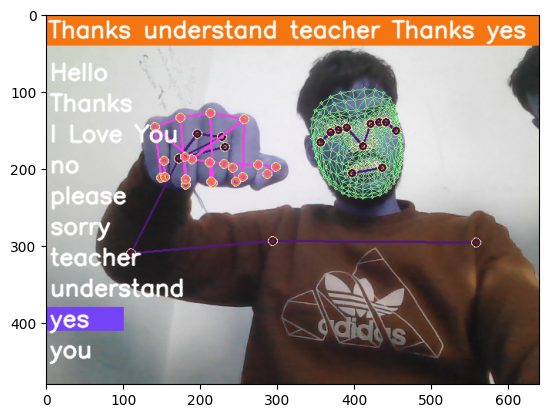

In [20]:
plt.imshow(prob_viz(res,actions,image,colors))

In [25]:
sequence = []
sentence = []
predictions = []
threshold = 0.1

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

        if len(predictions) >= 10 and np.unique(predictions[-10:])[0] == np.argmax(res):
            if res[np.argmax(res)] > threshold:
                if len(sentence) == 0 or actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])

        if len(sentence) > 5:
            sentence = sentence[-5:]

        if 'res' in locals():
            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Open CV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti